Parse the chat lines, the code assumes that the chat lines have a consistent format with the date, time enclosed in square brackets and then the sender, and content.
Create the dataframe

In [19]:
import pandas as pd
import re

def parsing(chatname: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    df = pd.DataFrame(columns=["date", "time", "sender", "content"])
    rows_with_removed_elements = pd.DataFrame(columns=df.columns)

    with open(chatname, "r", encoding="utf-8") as file: #name of the file
        date = None
        first_line_skipped = False #not a message

        for line in file:
            line = line.strip()
            if not first_line_skipped:
                first_line_skipped = True
                continue
            if "[" in line and "]" in line:
                if date is not None:
                    new_row = pd.DataFrame([[date, time, sender, content]], columns=["date", "time", "sender", "content"])
                    df = pd.concat([df, new_row], ignore_index=True) #insert the message found before
                
                    # Check for "<Media omitted>" and count for each participant
                    if "<Media omitted>" in content:
                        rows_with_removed_elements = pd.concat([rows_with_removed_elements, new_row])
                
                date_time, rest = line.split("]", 1) #create the variables
                date_time_clean = re.sub(r'[\[\]]', '', date_time)
                #print (date_time_clean)
                date, time = date_time_clean.split(" ")
                sender, content = rest.split(": ", 1)
            else:
                content += "\n" + line #the line found is still the message before

    if date is not None:
        new_row = pd.DataFrame([[date, time, sender, content]], columns=["date", "time", "sender", "content"])
        df = pd.concat([df, new_row], ignore_index = True)

        # Check for "<Media omitted>" in the last message and count for each participant
        if "Media omitted" in content:
            rows_with_removed_elements = pd.concat([rows_with_removed_elements, new_row])
    
    df = df[~df['content'].str.contains("Media omitted")] #problem: if someone sends a message with this content, it's just delated 
    return df, rows_with_removed_elements

In [40]:
df, rows_with_removed_elements = parsing("twopart_chat.txt")
df.head(10)

,date,time,sender,content
0,01/01/23,08:10:00,Bob,Hey! It was fantastic! Fireworks and good comp...
1,01/01/23,08:20:00,Alice,Same here! 2023 is off to a great start. Any r...
2,02/01/23,09:00:00,Bob,"Resolutions? Nah, I'm taking it one day at a t..."
3,02/01/23,09:10:00,Alice,Yes! I'm so excited. I've already bought ticke...
4,02/01/23,09:20:00,Bob,Awesome! We should plan to meet up before the ...
5,03/01/23,10:00:00,Alice,Sounds like a plan! Let's do it. Any preferenc...
6,03/01/23,10:10:00,Bob,How about that new Italian place downtown? Hea...
7,03/01/23,10:20:00,Alice,Perfect! Italian it is. Looking forward to goo...
8,04/01/23,11:00:00,Bob,"Me too! By the way, have you seen this funny c..."
9,04/01/23,11:10:00,Alice,"Haha, that's hilarious! Cats never fail to bri..."


In [41]:
def count_media() -> pd.DataFrame:
    df, rows_with_removed_elements = parsing("twopart_chat.txt")
    removed_counts = rows_with_removed_elements['sender'].value_counts().reset_index()
    removed_counts.columns = ['Sender', 'MediaCount']
    return removed_counts

removed_counts_df = count_media()
print("Media counts for each participant:")
print(removed_counts_df)

Media counts for each participant:
   Sender  MediaCount
0   Alice           1
1     Bob           1


In [22]:
from collections import Counter
import nltk 
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/beatricemusizza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Analyise the chat as a whole, finding the most common words used by each sender

In [23]:
def preprocess_text(text): 
    tokens = word_tokenize(text.lower())  #convert to lowercase
    tokens = [word for word in tokens if word.isalnum()]  #remove punctuation 
    return tokens

In [24]:
def most_common_words():
    sender_word_freq = {} #create an empty dictionary to store word frequencies for each sender
    grouped = df.groupby('sender') #group messages by sender
    #iterate through sender groups
    for sender, group in grouped:
        sender_tokens = []
        for message in group['content']: #preprocess each message and create a list for each sender
            message_tokens = preprocess_text(message)
            sender_tokens.extend(message_tokens)
        sender_word_freq[sender] = Counter(sender_tokens) #count word frequency for the sender and put into the dictionary
    return sender_word_freq

def print_common_words(sender_word_freq):
    for sender, word_freq in sender_word_freq.items():#analyze the most common words for each sender
            print(f'Sender: {sender}')
            most_common_words = word_freq.most_common(20)  
            for word, freq in most_common_words:
                print(f'{word}: {freq}')
            print()
            
sender_word_freq= most_common_words()
print_common_words(sender_word_freq)
#output (eventually) to improve

Sender:  Alice
i: 5
a: 5
the: 3
work: 3
go: 3
in: 2
on: 2
this: 2
check: 2
out: 2
could: 2
too: 2
nice: 1
stuck: 1
traffic: 1
usual: 1
monday: 1
struggle: 1
how: 1
about: 1

Sender:  Bob
a: 3
coffee: 3
any: 3
the: 3
to: 2
good: 2
that: 2
one: 2
you: 2
about: 2
let: 2
later: 2
work: 2
morning: 1
alice: 1
off: 1
start: 1
just: 1
had: 1
strong: 1

Sender:  Charlie
the: 4
it: 3
there: 2
let: 2
this: 2
weekend: 2
a: 2
hey: 1
doing: 1
fine: 1
planning: 1
to: 1
hit: 1
gym: 1
later: 1
yeah: 1
one: 1
with: 1
fancy: 1
desserts: 1

Sender:  David
the: 3
in: 2
for: 2
everyone: 2
you: 2
on: 2
hang: 1
there: 1
alice: 1
mondays: 1
are: 1
tough: 1
deal: 1
btw: 1
did: 1
see: 1
photo: 1
i: 1
sent: 1
from: 1



Since the simple analysis was not the meaningful (a lot of articles and prepositions) we will do a "stopword removal." 
Stopwords are words that are commonly used in a language but typically do not carry significant meaning by themselves. NLTK provides a list of stopwords for multiple languages.

In [25]:
#download the NLTK stopwords 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/beatricemusizza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
#remove stopwords
stop_words = set(stopwords.words('english'))
def remove_stop_words(tokens): 
    cleaned_tokens = [word for word in tokens if word not in stop_words]
    return cleaned_tokens

In [27]:
def most_common_words_stop():
    sender_word_freq = {} #create an empty dictionary to store word frequencies for each sender
    grouped = df.groupby('sender') #group messages by sender
    #iterate through sender groups
    for sender, group in grouped:
        cleaned_tokens = []
        for message in group['content']:
            tokens = preprocess_text(message)
            cleaned_token = remove_stop_words(tokens)
            if cleaned_token != "":
                cleaned_tokens.append(cleaned_token)
        flattened_tokens = [word for sublist in cleaned_tokens for word in sublist]
        sender_word_freq[sender] = Counter(flattened_tokens)
    return sender_word_freq
        
sender_word_freq= most_common_words_stop()
print_common_words (sender_word_freq)

Sender:  Alice
work: 3
go: 3
check: 2
could: 2
nice: 1
stuck: 1
traffic: 1
usual: 1
monday: 1
struggle: 1
movie: 1
night: 1
friday: 1
let: 1
comedy: 1
time: 1
need: 1
laughs: 1
awesome: 1
oh: 1

Sender:  Bob
coffee: 3
good: 2
one: 2
let: 2
later: 2
work: 2
morning: 1
alice: 1
start: 1
strong: 1
cup: 1
sounds: 1
great: 1
genre: 1
mind: 1
perfect: 1
bring: 1
popcorn: 1
haha: 1
gold: 1

Sender:  Charlie
let: 2
weekend: 2
hey: 1
fine: 1
planning: 1
hit: 1
gym: 1
later: 1
yeah: 1
one: 1
fancy: 1
desserts: 1
go: 1
thanks: 1
grab: 1
way: 1
plans: 1
tonight: 1
take: 1
care: 1

Sender:  David
everyone: 2
hang: 1
alice: 1
mondays: 1
tough: 1
deal: 1
btw: 1
see: 1
photo: 1
sent: 1
hike: 1
yesterday: 1
quiet: 1
night: 1
maybe: 1
catch: 1
shows: 1
good: 1
morning: 1
agenda: 1



Now I would like to create a word cloud based on the frequency counted and present in  sender_word_freq, the disctionary

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def print_word_cloud(sender_word_freq):
    wordcloud_dir = 'wordclouds' #create a directory to store word clouds
    for sender, word_freq in sender_word_freq.items(): #iterate through each sender and generate word clouds
        print(f'Sender: {sender}')
        most_common_words = word_freq.most_common(40)  #40 changeable

        word_freq_dict = dict(most_common_words) #from list to dictionary
        #The generate_from_frequencies method from the WordCloud class in the wordcloud library needs a dictionary where the keys are words, and the values are their corresponding frequencies (counts)

        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

        plt.figure(figsize=(5, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f'Word Cloud for{sender}')
        plt.show()

        # save the word cloud as an image (optional)
        # wordcloud.to_file(f'{wordcloud_dir}/{sender}_wordcloud.png')


Sender:  Alice


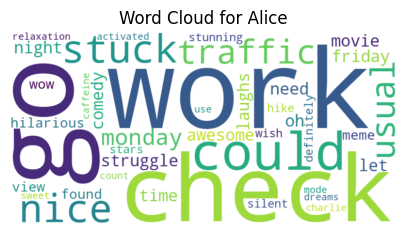

Sender:  Bob


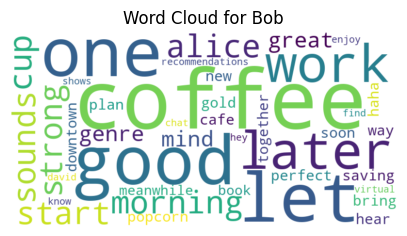

Sender:  Charlie


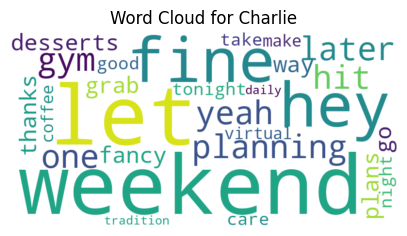

Sender:  David


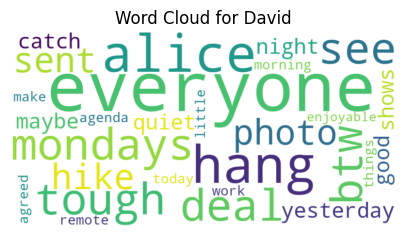

In [29]:
sender_word_freq= most_common_words_stop()
print_word_cloud(sender_word_freq)

Let's go on with some more sentiment analysis. We have already a function thay convert to lowercase, remove punctuation and remove stopwords. We already aslo have tokens. Anyway, we will label the whole messages, considering that single words don't have that much emaning. 
I will than calculate the average sentiment score for each sender. 

The function works by first grouping the messages by sender. Then, it creates a SentimentIntensityAnalyzer object from the NLTK library. This object is used to calculate the sentiment score of each message. The sentiment score is a float value between -1 and 1, where -1 indicates a very negative sentiment and 1 indicates a very positive sentiment.

Once the sentiment score of each message has been calculated, the function groups the scores by sender and calculates the average score for each sender. Finally, the function plots the average scores of all senders in a bar chart.

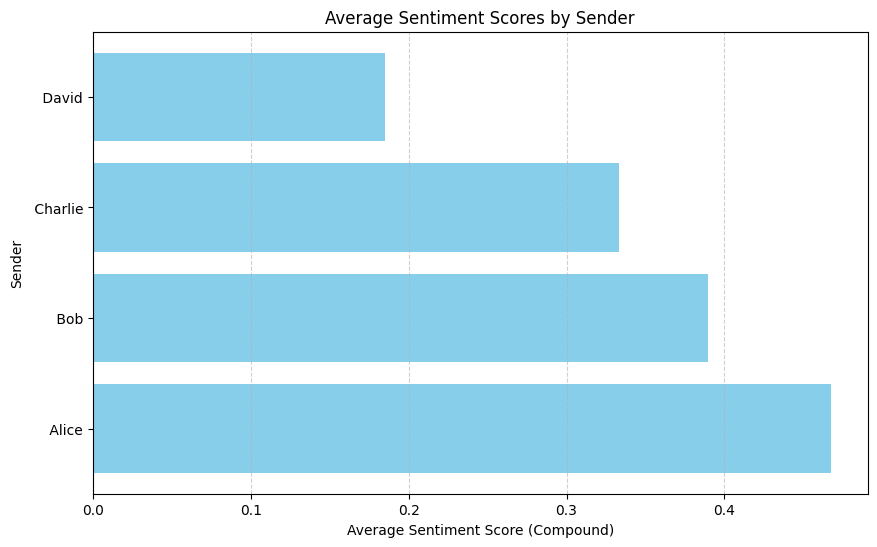

In [30]:
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import mark_negation


def score_calculation():

    grouped = df.groupby('sender')
    analyzer = SentimentIntensityAnalyzer()
    sender_scores= {}
    

    for sender, group in grouped:
        sentiment_scores = []
        for message in group['content']:
            tokens = preprocess_text(message)
            cleaned_messages = remove_stop_words(tokens) #a list of tokens
            text = " ".join(cleaned_messages) #join the cleaned tokens back into a text
            #analyze sentiment using the analyzer
            score = analyzer.polarity_scores(text)
            sentiment_scores.append(score)
        sender_scores[sender] = sentiment_scores
    return sender_scores,grouped

def average_calculation():
    sender_average_scores = {}
    sender_scores, grouped = score_calculation() 
    for sender, group in grouped:
        total_sender_scores = [scores['compound'] for scores in sender_scores[sender]]
        average_score = (sum(total_sender_scores)) / (len(total_sender_scores))
        sender_average_scores[sender] = average_score
    return sender_average_scores

def print_bar_chart():
    sender_average_scores = average_calculation()

    plt.figure(figsize=(10, 6))
    senders = list(sender_average_scores.keys())
    average_scores = list(sender_average_scores.values())
    plt.barh(senders, average_scores, color='skyblue')
    plt.xlabel('Average Sentiment Score (Compound)')
    plt.ylabel('Sender')
    plt.title('Average Sentiment Scores by Sender')
    plt.grid(axis='x', linestyle='--', alpha=0.6)

    plt.show()
print_bar_chart()


For each sender, now we print a graph with the total number for each category

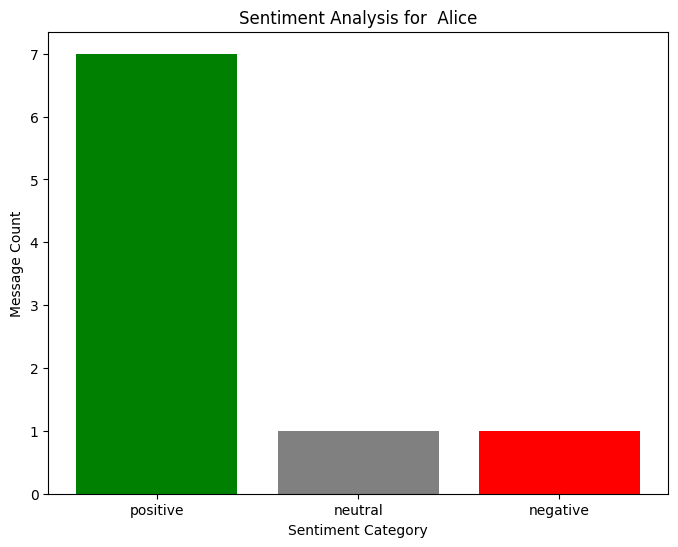

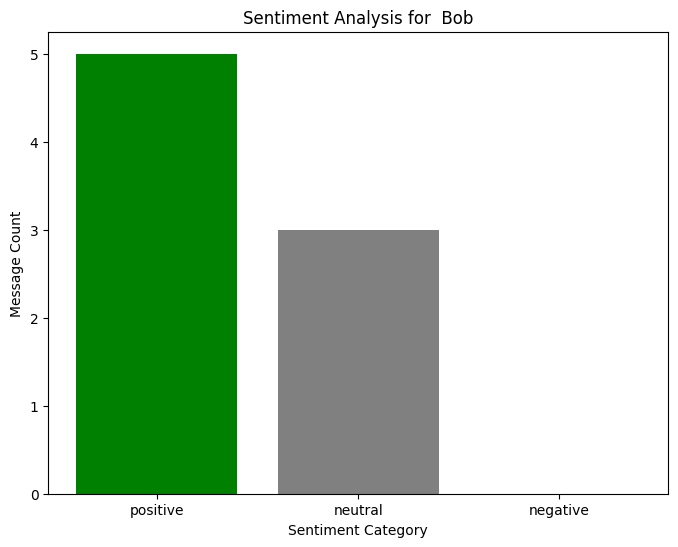

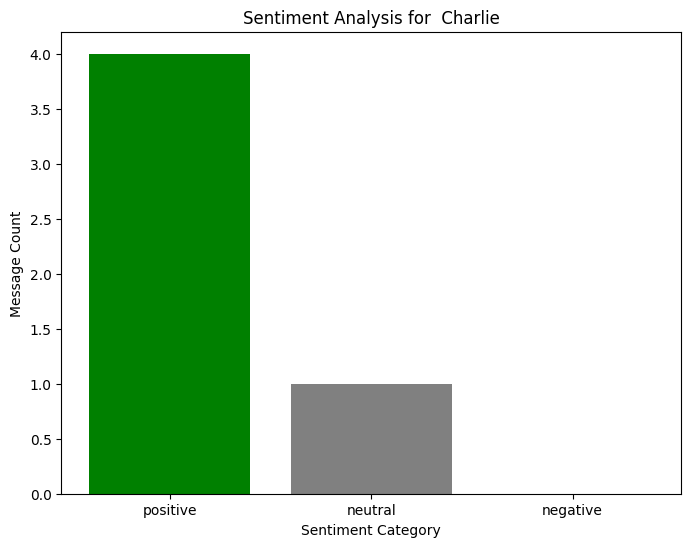

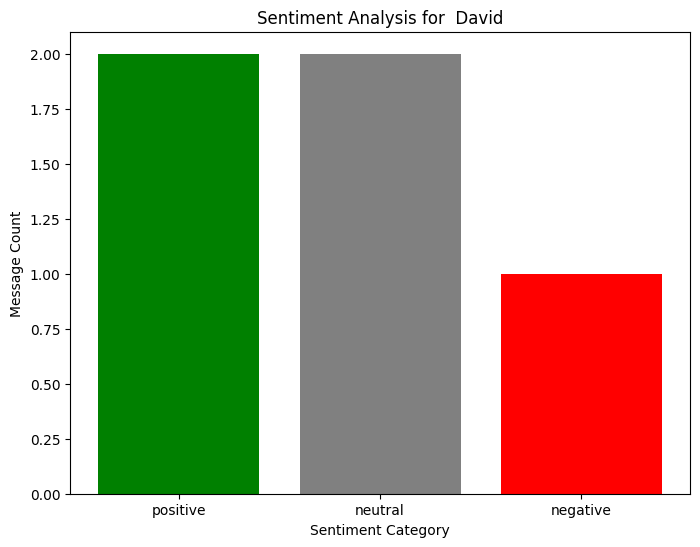

In [31]:
def messages_categories():
    sender_scores, grouped = score_calculation() #i have the dictionary with all the scores of messages for each sender {' sender1': [{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.0, 'neu': 1.0...

    categories = ['positive', 'neutral', 'negative']
    sender_sentiment_counts = {sender: {category: 0 for category in categories} for sender in grouped.groups}

    for sender, group in grouped:
        for scores in sender_scores[sender]:
            if scores['neg'] > 0.00:
                category = 'negative'
            elif scores['pos'] > 0.00:
                category = 'positive'
            else:
                category = 'neutral'
            sender_sentiment_counts[sender][category] += 1

    return sender_sentiment_counts, categories #the dict sender_sentiment_counts with the counts for each sender and each category

def category_graph():    
    sender_sentiment_counts,categories = messages_categories()
    for sender, cat_counts in sender_sentiment_counts.items(): #print
        plt.figure(figsize=(8, 6))
        plt.bar(categories, cat_counts.values(), color=['green', 'grey', 'red'])
        plt.xlabel('Sentiment Category')
        plt.ylabel('Message Count')
        plt.title(f'Sentiment Analysis for {sender}')
        plt.show()

category_graph()

Let's check how the library asses the points. For each sender, print only the content of messages that are considered negative or positive.

In [32]:
def pos_and_neg_messages():
    sender_scores, grouped = score_calculation()
    sender_sentiment_counts,categories = messages_categories()  #the dict sender_sentiment_counts with the counts for each sender and each category
    
    
    for sender, group in grouped:
        for score, message in zip(sender_scores[sender], group["content"]):
            if score['neg'] > 0.00:
                print(f'Message with a Negative component: {message}')
            elif score['pos'] > 0.00:
                 print(f'Message with a Positive component: {message}')
                 
pos_and_neg_messages()

Message with a Negative component: Nice! I'm stuck in traffic, the usual Monday struggle. 🚗
Message with a Positive component: Let's go for a comedy this time. Need some laughs!
Message with a Positive component: Awesome! Oh, and check out this hilarious meme I found. 😂
Message with a Positive component: Wow, the view is stunning! I wish I could go on a hike too.
Message with a Positive component: Definitely! Check out "The Silent Stars Go By." It's a page-turner.
Message with a Positive component: Same here. Relaxation mode activated. 😎
Message with a Positive component: You too, Charlie! Sweet dreams!
Message with a Positive component: Count me in! I could use a caffeine boost. ☕️
Message with a Positive component: Morning, Alice! Off to a good start. Just had a strong cup of coffee. ☕️
Message with a Positive component: Sounds great! Any genre in mind?
Message with a Positive component: Perfect! I'll bring the popcorn. 🍿
Message with a Positive component: Haha, that's gold! Saving t

Timeline Analysis: Plot the messages on a timeline to understand how the conversation evolved over time 

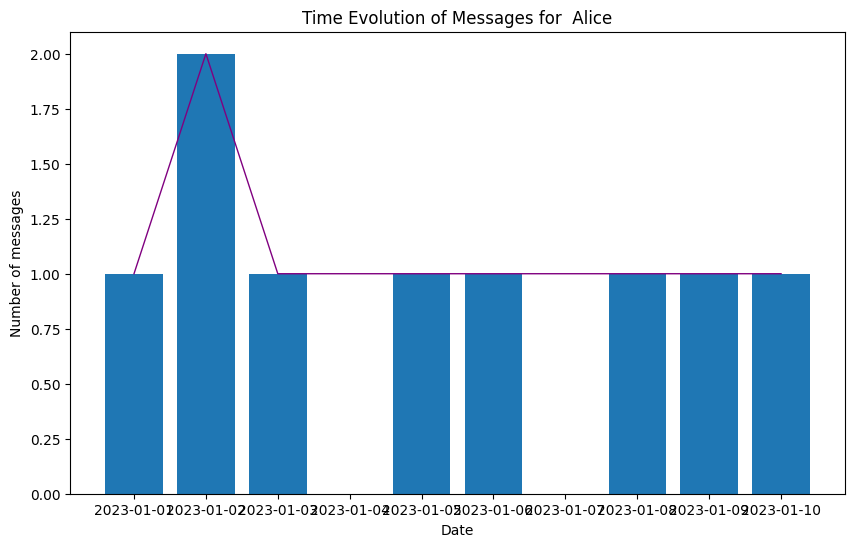

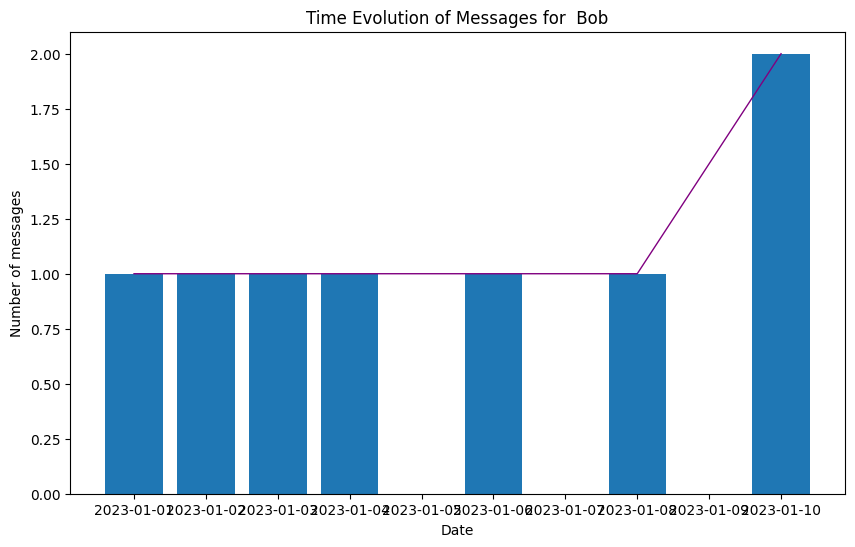

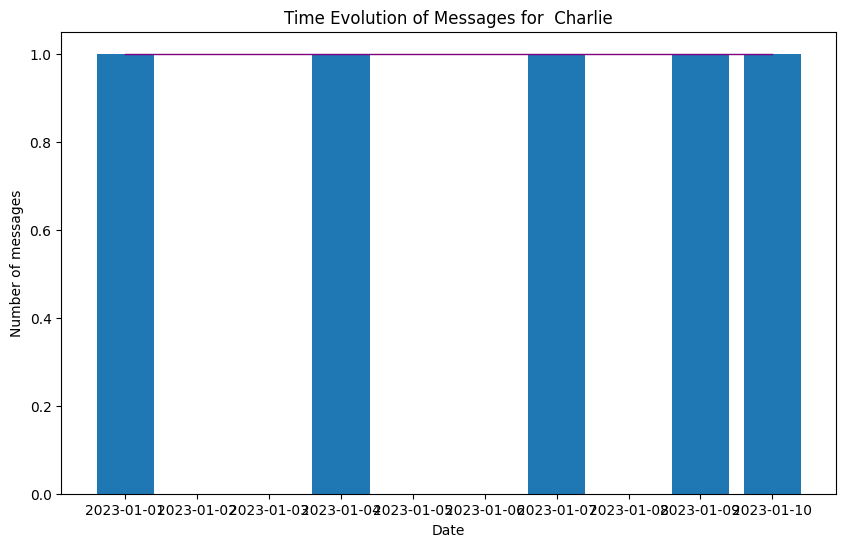

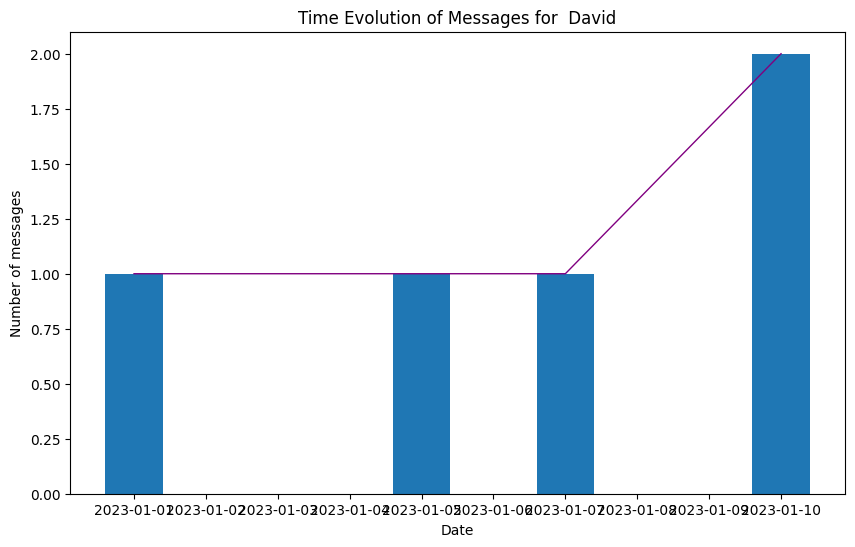

In [33]:
#for each sender i print the graph of the evolution of messages during time
def time_evolution():
    grouped = df.groupby('sender')
    for sender, dataofgroup in grouped:
        date_over_the_chat = pd.to_datetime(dataofgroup['date'], format="%d/%m/%y")
        counts= Counter(date_over_the_chat)
        dates = counts.keys()
        values = counts.values()

        

        plt.figure(figsize=(10, 6))
        plt.bar(dates, values)
        plt.xlabel("Date")
        plt.ylabel("Number of messages")
        plt.title(f'Time Evolution of Messages for {sender}')
        plt.plot(dates, values, color='purple', label='Cumulative Messages', linewidth=1)
       

        plt.show()

time_evolution()  

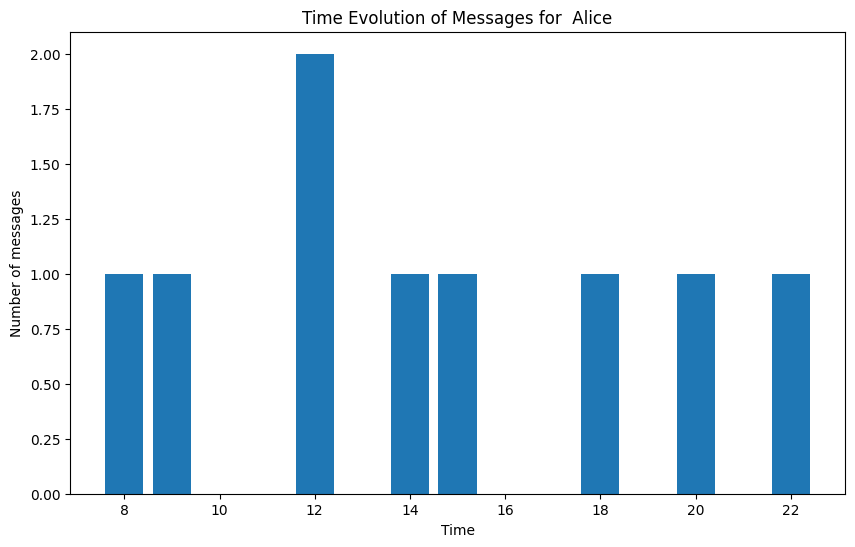

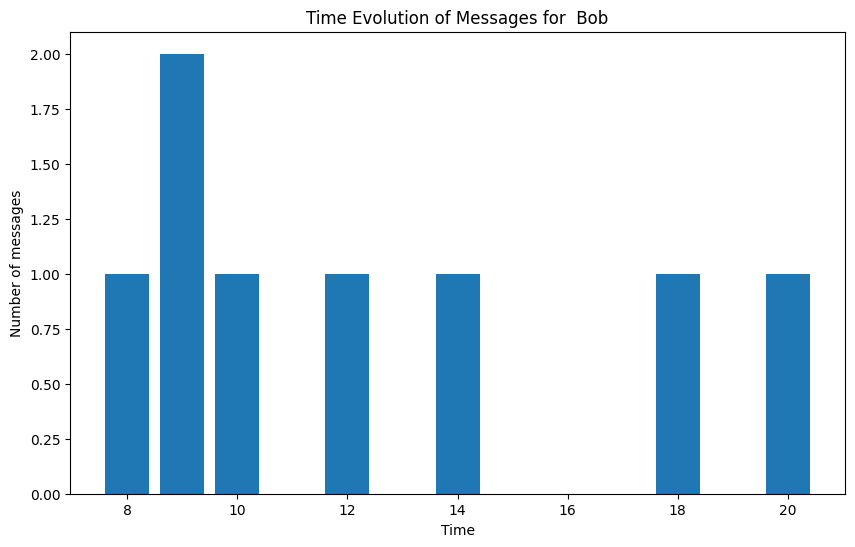

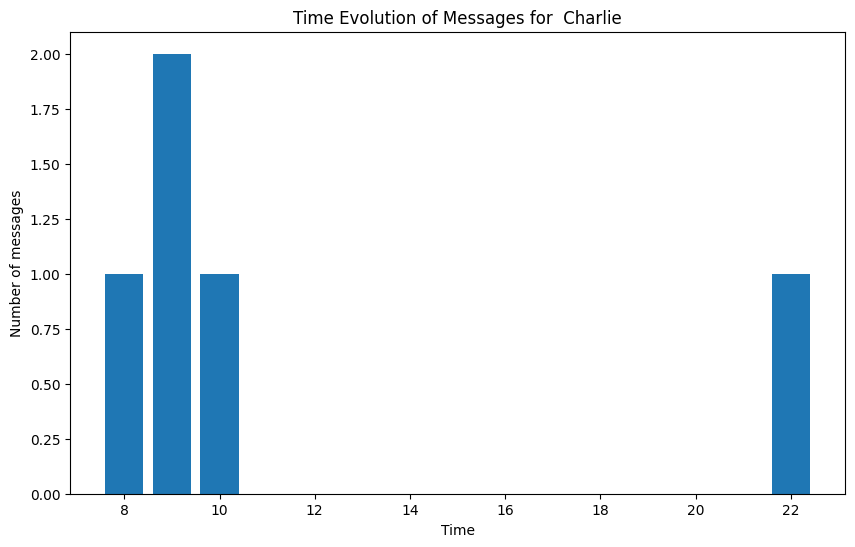

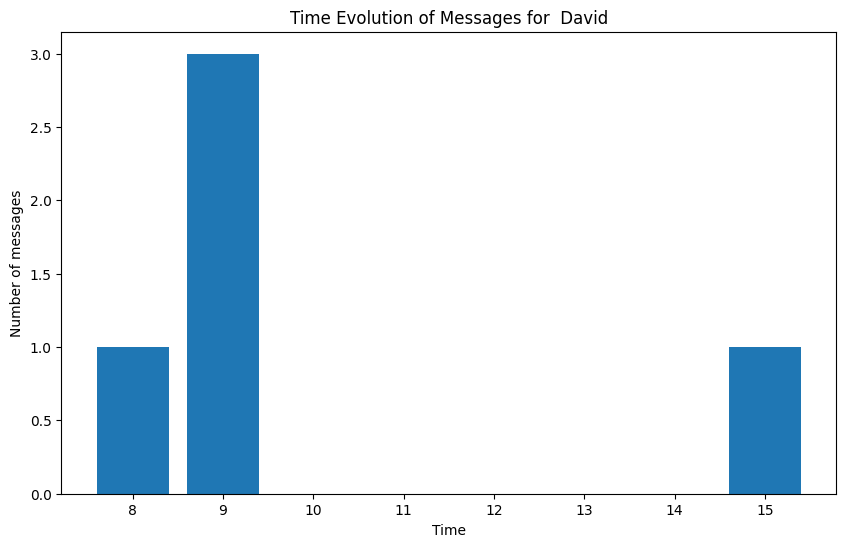

In [34]:
#for each sender i print the graph of the evolution of time, to undestand in which part of the day we have more messages

def time_during_day_evolution():
    grouped = df.groupby('sender')
    for sender, dataofgroup in grouped:
        timesin_the_chat = sorted(pd.to_datetime(dataofgroup['time'], format="%H:%M:%S").dt.hour)
        timecount= Counter(timesin_the_chat)
        times = timecount.keys() 
        values =  timecount.values() 

        plt.figure(figsize=(10, 6))
        plt.bar(times, values)
        plt.xlabel("Time")
        plt.ylabel("Number of messages")
        plt.title(f'Time Evolution of Messages for {sender}')
        plt.show()

time_during_day_evolution()  

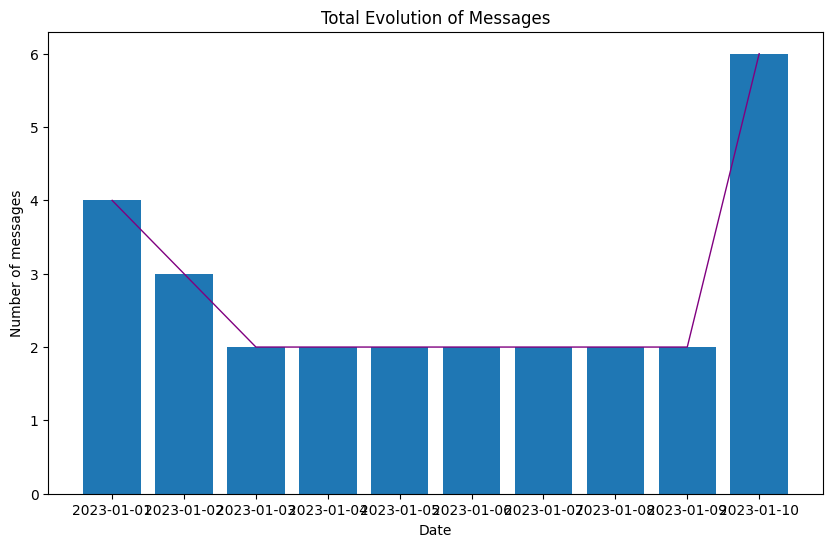

In [35]:
#i print the graph of the evolution of time in total (for groups, not for each sender)

def time_evolutiontot():
    
    date_over_the_chat = pd.to_datetime(df['date'], format="%d/%m/%y")
    countstot= Counter(date_over_the_chat)
    dates = countstot.keys()
    values = countstot.values()
        
    plt.figure(figsize=(10, 6))
    plt.bar(dates, values)
    plt.xlabel("Date")
    plt.ylabel("Number of messages")
    plt.title(f'Total Evolution of Messages')
    plt.plot(dates, values, color='purple', label='Cumulative Messages', linewidth=1)
       

    plt.show()

time_evolutiontot()  